# EDA & Hypothesis Testing on Data from Yelp on the Bay Area Tri-Cities

## Imports

In [1]:
# necessary imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Inspection & Preliminary Cleaning

I start by first reading the scraped data into a pandas DataFrame:

In [2]:
tri_city_df = pd.read_csv('tri_city_data.csv')
tri_city_df = tri_city_df.drop_duplicates() # There are duplicates in the data that need to be dropped
len(tri_city_df)

365

As expected from the way I scraped the Yelp data and wrote into `tri_city_data.csv`, the `tri_city_df` schema is:
* Each tuple is a unique business containing the features:
    * `business_id`: the primary key of the business
    * `name`: name of the business
    * `city`: the city the business is located in
    * `review_count`: total number of reviews the business recived as of 4/13/2023
    * `rating`: the cumulative rating calculated from the reviews the business received as of 4/13/2023

Before moving on to proper EDA, I realized I needed to some some preliminary cleaning.

In the `name` column, it appears that the apostrophe character in the data **’** is somehow *different* from the apostrophe character on my keyboard **'**. The former seems to be curved whereas the latter is straight. A quick Google search led me to this [Stack Overflow post](https://stackoverflow.com/questions/6711892/right-single-apostrophe-vs-apostrophe). To deal with this, I will use regex to replace the slanted apostrophe with the straight apostrophe.

In [3]:
# Replace slanted apostrophe ’ with straight apostrophe '
tri_city_df['name'] = tri_city_df['name'].str.replace("’", "'")

# Check if properly replaced
print("McDonald's" in tri_city_df['name'].values)

True


The check returned `True`, meaning the replacement was successful. 

Next, I need to categorize each business as whether or not it is a commonly franchised fast food restaurant. I create a new feature called `is_ff_chain`, which will take on value $1$ if it is a commonly franchised fast food restaurant as defined by the list mentioned in the README, otherwise $0$.

The list is reproduced here:
`["Burger King", "Carl's Jr", "Chick-fil-A",  "Chipotle Mexican Grill", "McDonald's",
                 "Firehouse Subs", "Five Guys", "Jack in the Box", "KFC", "Panda Express",
                 "Papa Johns Pizza", "Popeyes Louisiana Kitchen", "Subway", "Taco Bell",
                 "Wendy's", "Wienerschnitzel", "Wingstop"]`

In [4]:
# Defined list
ff_chain_list = ["Burger King", "Carl's Jr", "Chick-fil-A",  "Chipotle Mexican Grill", "McDonald's",
                 "Firehouse Subs", "Five Guys", "Jack in the Box", "KFC", "Panda Express",
                 "Papa Johns Pizza", "Popeyes Louisiana Kitchen", "Subway", "Taco Bell",
                 "Wendy's", "Wienerschnitzel", "Wingstop"]

# Create new feature `is_ff_chain`
tri_city_df['is_ff_chain'] = tri_city_df['name'].isin(ff_chain_list)

## Exploration

### Proportion and Distribution

Starting with something simple, I was curious about the proportion of commonly franchised fast food restaurants (fast food chains) to restaurants in the Tri-City area.

In [5]:
# Display number of commonly franchised fast food restaurants (ff_chains) are in the tri-city area
print("Num ff_chains: {:27}".format(len(tri_city_df[tri_city_df['is_ff_chain']])))

# Display number of total restaurants in tri-city area
print("Num restaurants: {:26}".format(len(tri_city_df)))

# Display proportion of ff_chains in tri-city area
print("Proportion of ff_chains to restaurants: {0:.4f}".format(len(tri_city_df[tri_city_df['is_ff_chain']])/len(tri_city_df) ))

Num ff_chains:                          63
Num restaurants:                        365
Proportion of ff_chains to restaurants: 0.1726


Roughly $17\%$ of all restaurants in the Tri-City area are fast food chains. Not sure how significant this number is, but this seems to be quite a lot. Might be a cool topic to look into in a future project.

Next, I wanted to see the distribution of ratings for ff_chains and non-fast-food restaurants.

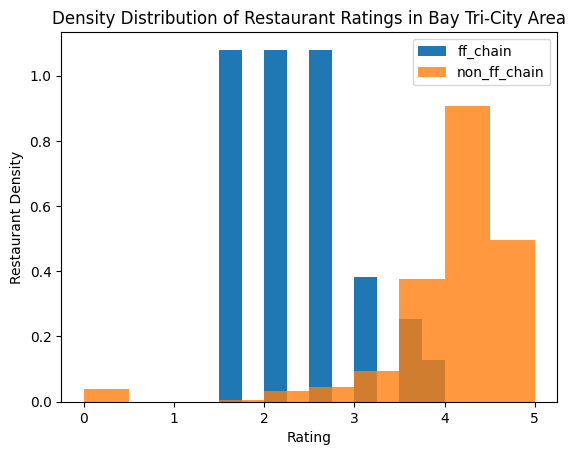

In [6]:
# Get series of ff_chain ratings
ff_chain_rating_series = tri_city_df[tri_city_df['is_ff_chain']]['rating']

# Get series of non ff_chain ratings
non_ff_chain_rating_series = tri_city_df[~tri_city_df['is_ff_chain']]['rating']

# Plot the two histograms overlaid
plt.hist(ff_chain_rating_series, alpha=1, label='ff_chain', density=True)
plt.hist(non_ff_chain_rating_series, alpha=0.8, label='non_ff_chain', density=True)
plt.legend()
plt.title("Density Distribution of Restaurant Ratings in Bay Tri-City Area")
plt.xlabel('Rating')
plt.ylabel('Restaurant Density')
plt.show()

Observations:
* `ff_chain` distribution:
    * Centered around $2.5$.
    * Three peaks, one at $1.5, second at $2$, and third and $2.5$.
    * Exhibits a right skew, meaning mean $>$ median.
* `non_ff_chain` distribution:
    * Centered around $4$.
    * Unimodal, one peak at around $4$.
    * Exhibits a left skew, meaning mean $<$ median.

In comparing the two distribution densities, I think it is quite clear that the rating distribution for fast food chains is based to the left of that of normal restaurants. In other words, the ratings of fast food chains are on average lower than the ratings of normal restaurants.

These observations now raise my main question:

**Is the difference in ratings simply a result of chance variation or is there a *real* difference between the two distributions?**

### Restaurants with a Rating of 0

But before I attempt to answer that question, I would like to investigate the data a little bit further. Something that caught my eye was that there is a sizeable density located in the $[0, 0.5)$ rating bin. I want to know what restaurants they are.

In [7]:
tri_city_df[tri_city_df['rating']==0]

,business_id,name,city,review_count,rating,is_ff_chain
20,MkiwFVtXog0EWdQHm37S_g,flaming house,newark,0,0.0,False
100,StOsDpqb8xoDFPr4vKQcmA,Super Mega Dilla,newark,0,0.0,False
152,L_0CHuwKDqkY4ZYI6yAEtg,Old Street Chengpan Malatang,fremont,0,0.0,False
175,uyJIoXr3uMyHr4b8OKaoWw,My Indian Pizza,fremont,0,0.0,False
289,fHEqmzVrXSo956OLCB7r-w,Auntie Anne's,fremont,0,0.0,False
393,JRofmKaZVYnwMEuWlwOOlA,Grill City,union city,0,0.0,False


From these results, I think it is safe to assert that these restaurants received a rating of $0$ simply because they've never received a user review before. But how is it the case that there `review_count` is $0$? I decided to take a look at the yelp pages of each of these restaurants.

**[flaming house](https://www.yelp.com/biz/flaming-house-newark-6#location-and-hours)**

<div>
<img src=img/flaming_house.png width=1000>
</div>

From a brief glance at the restaurant page, I believe this restaurant may have opened up recently. As shown by the picture, their opening hours were updated $1$ month ago, and from looking at the eight pictures that have been posted so far, **six** of them were posted by the business themselves and two were potentially taken by customers. I say potentially because one of the two pictures is the exact same picture posted by the business; I believe there are only two explanations for this: 1) The user is the business owner and forgot to change accounts to post on their business account or 2) the business decided to repost the user's picture.

Regardless, despite having two Yelp users posting pictures, none of them left a review. And considering this business only opened up recently, I don't think I can make a justifiable assessment on the quality of this restaurant.

**[Super Mega Dilla](https://www.yelp.com/biz/super-mega-dilla-newark?osq=super+mega+dilla)**


<div>
<img src=img/super_mega_dilla.png width=1000>
</div>

An unclaimed restaurant, but more notably it has a "Fast Food" tag (explains how my scraper caught it) and a "Food Dellivery Services" tag. The latter disqualifies it from participating in this project.

**[Old Street Chengpan Malatang](https://www.yelp.com/biz/old-street-chengpan-malatang-fremont)**

<div>
<img src=img/old_street_chengpan_malatang.png width=1000>
</div>

I have walked by this restaurant before, so I know why there are no reviews: it is not open yet. A quick look through its posted pictures also confirms this:

<div>
<img src=img/old_street_chengpan_malatang_opening_soon.png width=500>>
</div>

**[My Indian Pizza](https://www.yelp.com/biz/my-indian-pizza-fremont?osq=my+indian+pizza)**

!['my_indian_pizza_img'](img/my_indian_pizza.png)

This next restaurant is the most interesting one. It's a claimed restaurant, but there are no photos posted, neither by the business owner nor users. No business hours are listed either. So I dug deeper by searching up their address on Google Maps and using the [street view functionality](https://www.google.com/maps/@37.5335553,-121.9979814,3a,38y,319.87h,85.74t/data=!3m7!1e1!3m5!1sFPEXYB5BqN3sZ6owAXM9RA!2e0!6shttps:%2F%2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail%3Fpanoid%3DFPEXYB5BqN3sZ6owAXM9RA%26cb_client%3Dmaps_sv.tactile.gps%26w%3D203%26h%3D100%26yaw%3D192.10873%26pitch%3D0%26thumbfov%3D100!7i16384!8i8192) to see if the restaurant is actually there. To my surprise, I observe the following:

<div>
<img src=img/5176_mowry_ave.png width="750">
</div>

A different restaurant called Papa Murphy's Pizza? Searching up this restaurant yielded the following results:

<div>
<img src=img/papa_murphys.png width=750>
<img src=img/papa_murphys_hours.png width=500>
</div>

The addresses for these two "restaurants" match, so that shouldn't be a mistake. However, it shows on Papa Murphy's page that "Yelpers report this location has closed." At the same time, the street view was last updated on December 2020. So is the restaurant My Indian Pizza actually there? I guess I would never know unless I decide to drive over and check it out (or I could just call them, a phone number is listed...). Until then, I guess I'll never know.

**Auntie Anne's**

![auntie_annes_img](img/auntie_annes.png)

The scraped data doesn't exist in the search page? Cross referencing the search results with the map provided by yelp, it appears that there isn't supposed to be an Auntie Anne's in the city of Fremont (the first search result is located in a mall in Newark). So I'm not entirely sure how my scraper acquired this data.

[Grill City](https://www.yelp.com/biz/grill-city-union-city-2?osq=Grill+City)

<div>
<img src=img/grill_city.png width=1000>
</div>

Claimed business with hours listed, but no reviews. All the photos posted are done by the business themselves. I noticed that this seemed to be a franchised restaurant and they had their own website. Perusing thereof led to the following [discovery](https://www.grillcity.com/northern-california/):

<div>
<img src=img/grill_city_norcal_locations.png width=750>
</div>

I believe it is safe to assume that the Union City location of Grill City is no longer in business, if it had ever been in business before.

All in all, from looking at all these individual restaurants, I believe they can all be considered as outliers and removed from the final data set. There are only five elements, so it shouldn't affect the data that much, but I remove them regardless:

In [8]:
# Remove the restaurants with a rating of 0
tri_city_df = tri_city_df[tri_city_df['rating']!=0]
print(len(tri_city_df)) # should print 359 (365 - 6 = 359)

359


## Hypothesis Testing - A/B Test

Finally, moving on to answering the question posed in exploration. To reiterate, I wish to answer the following:

**Is the difference in ratings simply a result of chance variation or is there a *real* difference between the two distributions?**

To answer that, I will perform an A/B test with the following hypotheses:

**Null Hypothesis:** In the Bay Area Tri-City area, the distribution of ratings is the same for regular restaurants and commonly franchised fast food restaurants. The difference in the sample is due to chance.

**Alternative Hypothesis:** In the Bay Area Tri-City area, the commonly franchised fast food restaurants have a *lower* rating, on average, than regular restaurants.

For my test statistic, I will be using the difference between the two group's rating averages, specifically the average rating of non-fast-food chain restaurants *minus* the average rating of fast food chains. This means that larger values will favor the alternative hypothesis. A naive $\alpha=0.05$ will be used as the cutoff point.

To start, I will compute the observed value of the test statistic.

In [9]:
# Display the average rating of the two groups
average_ratings = tri_city_df[['rating', 'is_ff_chain']].groupby('is_ff_chain').mean()
print(average_ratings)

# Compute the test statistic (0th value is regular restaurants, 1st is chain)
obs_diff = average_ratings.values[0][0] - average_ratings.values[1][0]
print('\nObserved Difference: {:.4f}'.format(obs_diff))

               rating
is_ff_chain          
False        3.918919
True         2.253968

Observed Difference: 1.6650


The observed test statistic, or the difference in average ratings between the two groups, non-fast-food chain average rating minus fast food chain average rating, is around $1.67$.

Next, I will implement a Python function that performs A/B testing: shuffling labels, simulating samples, and compute the test statistic.

In [10]:
# Function that performs the A/B test.
# Takes in the DataFrame, the name of the column to be averaged, the label to group by,
# the observed difference, and a naive alpha value (p-value cutoff).
# Plots the distribution density of the average differences, concludes whether or not to reject
# the null hypotheseis, and returns the empirical p-value.

def ab_test(df, col, group, rep, obs_diff, alpha):

    # Helper function for ONE simulation of the hypothesis test
    def simulate_test(df, group):
        # Shuffle labels, must sample with replacement
        new_labels = df.sample(len(df), replace=True).reset_index()[group]
        # Project desired columns and add shuffled labels
        sample_df = df[[col]] # projection
        sample_df['shuffled_label'] = new_labels
        # Get averages of the two groups (0th value is regular restaurants, 1st is chain)
        sample_df_series = sample_df.groupby('shuffled_label').mean()
        sample_diff = sample_df_series[col][0] - sample_df[col][1]
        return sample_diff
    
    # Use helper function to compute test statistic. Repeat for rep repetitions
    test_statistic_list = np.array([])
    for _ in np.arange(rep):
        sim_test_statistic = simulate_test(df, group)
        test_statistic_list = np.append(test_statistic_list, sim_test_statistic)
    
    empirical_p = np.count_nonzero(test_statistic_list >= obs_diff)/ rep

    # Plot the distribution density of the average differences
    plt.hist(test_statistic_list, density=True)
    plt.grid()
    plt.scatter(obs_diff, 0.2, color='red')
    plt.title('Density Distribution of Average Differences Under the Null')
    plt.xlabel('Average Difference')
    plt.ylabel('Average Difference Density')

    # Print conclusions
    print('Simulation under the Null with {} repetitions'.format(rep))
    print("With naive \u03B1={} and empirical p-value={},".format(alpha, empirical_p))
    print("we {} the null hypothesis".format("FAIL TO REJECT" if empirical_p > alpha else "REJECT"))
    return empirical_p
        




With the `ab_test` function implemented, I now perform the A/B test:

Simulation under the Null with 5000 repetitions
With naive α=0.05 and empirical p-value=0.0,
we REJECT the null hypothesis


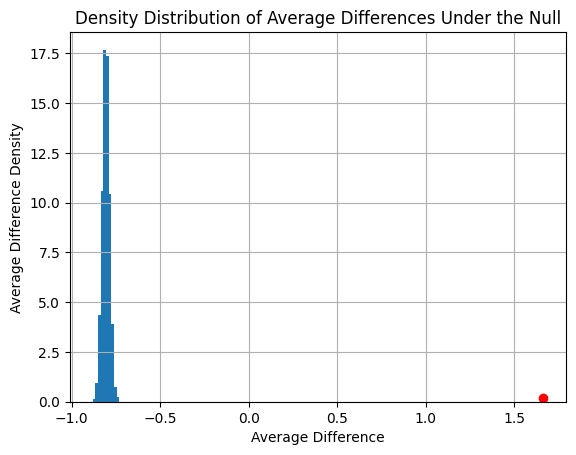

In [11]:
# Suppress SwettingwithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Perform the A/B test
empirical_p = ab_test(tri_city_df, 'rating', 'is_ff_chain', 5000, obs_diff, 0.05)

Reiterating again the parameters of my A/B test. With a naive $\alpha=0.05$, our p-value cutoff, and by simulating under the null hypothesis, I obtained a p-value of $0.0$, and computation is reinforced by the histogram. The histogram is centered around $0.1$, mostly unimodal, and with very little spread, and we can see that our observed value (the red dot) is way far off to the right of the plot.

Finally, since our empirical p-value of $0.0$ is ***less** than our $\alpha=0.05$, we reject our null hypothesis and lean towards the alternative, meaning our test supports the hypothesis that in the Bay Tri-City area, commonly franchised fast food restaurants or fast food chains have lower ratings on average than regular restaurants.

## Curating a Restaurant *Trial* List

As I mentioned in my README, one of the reasons for starting this project was to find ~~good~~ *edible* restaurants in the Bay Tri-City area. My hypothesis test does not fully accomplish that; it just confirms that fast food restaurants in general suck more on average than normal restaurants.

Thus, I want to at least curate a list of highly reviewed restaurants for us to ***try***. To do that, I return to `tri_city_df`.

In [12]:
tri_city_df.head()

,business_id,name,city,review_count,rating,is_ff_chain
0,CcbFduunKlsrnW71-PH0ZA,Pocha K,newark,55,4.5,False
1,purj1aiUzDi0I__qLOaNRg,四姐 Pan Fried Dumplings,newark,613,4.5,False
2,1y4juqtkSJ9DPPZyRMi-xA,Mingkee Deli,newark,17,3.5,False
3,9Shb0yRis5NEQ5xIGG0FcA,Duobao BBQ & Dumplings,newark,43,4.5,False
4,i_GuYJ_1hmW-lHeQ4GmOiw,Lazy Dog Restaurant & Bar,newark,1617,4.0,False


In general, my dad and I already have a mentally established list of fast food joints that are our defaults, and admittedly we go there quite often. Thus, I start by filtering out the fast food chains in `tri_city_df` to create our new `trial_df`.

In [13]:
# Get rid of fast food restaurants
trial_df = tri_city_df[~tri_city_df['is_ff_chain']]
trial_df.head()

,business_id,name,city,review_count,rating,is_ff_chain
0,CcbFduunKlsrnW71-PH0ZA,Pocha K,newark,55,4.5,False
1,purj1aiUzDi0I__qLOaNRg,四姐 Pan Fried Dumplings,newark,613,4.5,False
2,1y4juqtkSJ9DPPZyRMi-xA,Mingkee Deli,newark,17,3.5,False
3,9Shb0yRis5NEQ5xIGG0FcA,Duobao BBQ & Dumplings,newark,43,4.5,False
4,i_GuYJ_1hmW-lHeQ4GmOiw,Lazy Dog Restaurant & Bar,newark,1617,4.0,False


Intuitively, I check the top $10$ restaurants sorted by rating:

In [14]:
trial_df.sort_values('rating', ascending=False).head(10)

,business_id,name,city,review_count,rating,is_ff_chain
130,j_Tko7_HIrjx334lmI8Dtg,Afghan Awasana Kabob,fremont,294,5.0,False
66,LZwp2yd1Abs8PDF1Wf8Ybg,Dat Q BBQ,newark,17,5.0,False
5,FQnIs9ojngandeHW4UrasA,California Soul Food,newark,3,5.0,False
49,vu9iWvr8SUtpzQratYasXw,Emperor Dynasty Banquet,newark,7,5.0,False
216,Qgyf5wWw3SHCiohkr2Xlpw,Bundoo Khan,fremont,7,5.0,False
113,mog4wAikb1EnzwWSnKt-BQ,Tamper Room,fremont,38,5.0,False
118,W_HLI03d4OxtcY0pTYpnNA,Five Grains Noodle House,fremont,1,5.0,False
354,cGTNaphwexAJkuK628XgUw,Cock n' Curry - Indian Fried Chicken,union city,4,5.0,False
117,UhMdgcDu6zRADR43uhyfYg,Billy Roys Burger,fremont,285,4.5,False
129,WQInMCxF3EpwgvQa2vLQsg,SOHO Modern Japanese,fremont,187,4.5,False


Here, I encounter my first problem. A restaurant may have a high rating, but it may not have a lot of reviews. Thus, how do you incorporate `review_count` and `rating` together? Because clearly, a restaurant with $200$ reviews and a rating of $4.5$ should be considered more credible than a restaurant with $1$ review but a rating of $5.0$. I turned to Google to see if Yelp has revealed their rating algorithm; to no surprise, it is [proprietary](https://www.quora.com/How-does-the-rating-algorithm-of-Yelp-work). I'm going to have to create my own set of rules.

To start, I want to determine a "threshold" number of reviews a restaurant must have to be deemed "credible" enough. However, this means that there might be potential sleepr restaurants that I might miss, but I the probablility of this is low and I rather not be a guinea pig. If the restaurant is actually good, I'm confident the number of reviews will increase over time, and I am more than happy to wait it out; I've already suffered for more than six years, what's another few months.

So to determine that threshold, I want to see the spread of `review_count`. I implement a Python function that makes a boxplot and displays a statistical summary containing the count, mean, standard deviation, min, median, max, and $25th$ and $75th$ percentile.

In [15]:
# Helper method that visualizes the spread of a DataFrame and displays summary statistics
# Takes in a DataFrame and the name of a column of interest
def boxplot_and_summary(df, col):
    # Make a boxplot of review_count
    plt.boxplot(df[col])
    plt.title("Boxplot of {}".format(col))
    plt.xlabel(col)
    plt.ylabel("Num {}".format(col))
    plt.grid()
    plt.show()

    # Show summary statistics of col
    print("Summary Statistics:")
    print(df[col].describe())

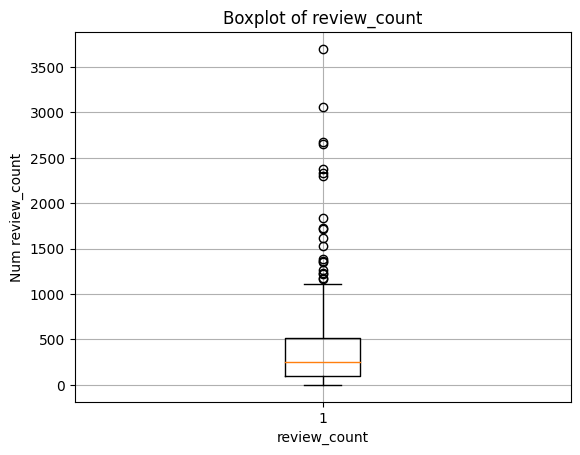

Summary Statistics:
count     296.000000
mean      411.574324
std       506.817616
min         1.000000
25%        96.000000
50%       251.000000
75%       518.750000
max      3698.000000
Name: review_count, dtype: float64


In [16]:
# Call boxplot_and_summary on `trial_df``
boxplot_and_summary(trial_df, 'review_count')

From looking at the boxplot, there appears to be a lot of outliers in the higher end; I do not want to use these data points to determine my threshold. Thus, I will use the [IQR](https://en.wikipedia.org/wiki/Interquartile_range) to determine my boxplot's upper whisker, which can be computed with the following formula:

$$Q_3 + 1.5*IQR$$

where $IQR=Q_3 - Q_1$

and $Q_1$ and $Q_3$ is the $25th$ and $75th$ percentile respectively.

All points above the upper whisker will not be considered in determining my personal threshold. In the following cell, I implement a Python function that calculates the upper whisker of a boxplot:

In [17]:
# Python function that computes the upper whisker of a boxplot using the data's IQR.
# Takes in a DataFrame and the name of the column of interest
# Returns the value of the boxplot's upper whisker.
def compute_upper_whisker(df, col):
    q1 = df[col].describe()['25%']
    q3 = df[col].describe()['75%']
    iqr = q3 - q1
    return q3 + 1.5 * iqr

# Call above function to find upper whisker
upper_whisker = compute_upper_whisker(trial_df, 'review_count')
print("Upper Whisker Threshold: {}".format(upper_whisker))

Upper Whisker Threshold: 1152.875


There is no way to have a decimal number of reviews, so I will round down. To determine my personal threshold, I will remove all restaurants containing *more than* $1152$ reviews.

In [40]:
# Helper method that I decided to implement to give me removal stats, more
# specifically, it will show how many tuples and proportion of tuples removed from
# one DataFrame, prev_df, to another, curr_df.
# Will simply print these removal stats.
def removal_stats(prev_df, curr_df):
    print("Number of tuples removed: {:6}".format(len(prev_df) - len(curr_df)))
    print("Proportion of tuples removed: {:.4f}".format((len(prev_df) - len(curr_df)) / (len(prev_df))))
    print("Remaining tuples: {:15}".format(len(curr_df)))

In [41]:
# Create `threshold_df` by filtering through `trial_df` with `upper whisker`
threshold_df = trial_df[trial_df['review_count'] <= upper_whisker]
removal_stats(trial_df, threshold_df) # display removal stats

Number of tuples removed:     20
Proportion of tuples removed: 0.0676
Remaining tuples:             276


$20$ restaurants or roughly $6.8\%$ of the restaurants were removed from `trial_df` to create `threshold_df`. This might be a lot, but I think it should be fine, and this is my ***personal*** threshold, so I make the rules here.

Next, I take a look at the spread and summary statistics for `threshold_df`.

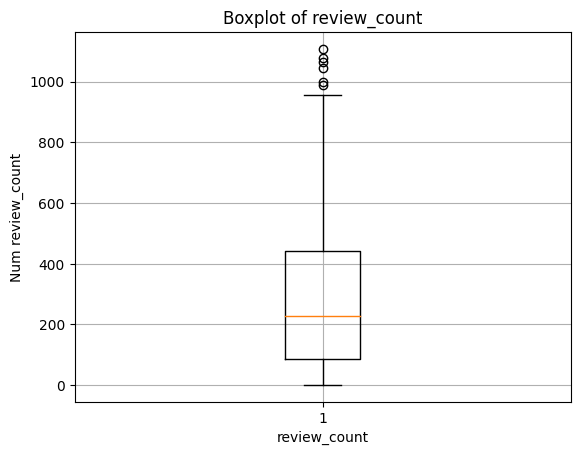

Summary Statistics:
count     276.000000
mean      304.985507
std       266.533068
min         1.000000
25%        84.750000
50%       226.500000
75%       443.000000
max      1108.000000
Name: review_count, dtype: float64


In [42]:
# Call boxplot_and_summary on `threshold_df``
boxplot_and_summary(threshold_df, 'review_count')

From looking at the spread of `threshold_df`, I'm tempted to use the first quartile as my personal threshold. Before going a long with that, I want to see the distribution of `review_count`.

In [49]:
# Fucntion that makes a histogram of `col` in `df`
# Takes in a Dataframe, `df`, a column of interest, `col`, and a optional parameter `r_bins`
# to specifiy a range for the bins
# Displays a histogram
def plot_distribution(df, col, r_bins=0):
    # Needed in case there is an r_bins argument
    if (r_bins==0):
        plt.hist(df[col])
    else:
        plt.hist(df[col], bins=r_bins)
    
    plt.title('Distribution of {} of Restaurants'.format(col))
    plt.ylabel('Num restaurant with {}'.format(col))
    plt.xlabel(col)
    plt.grid()
    plt.show()

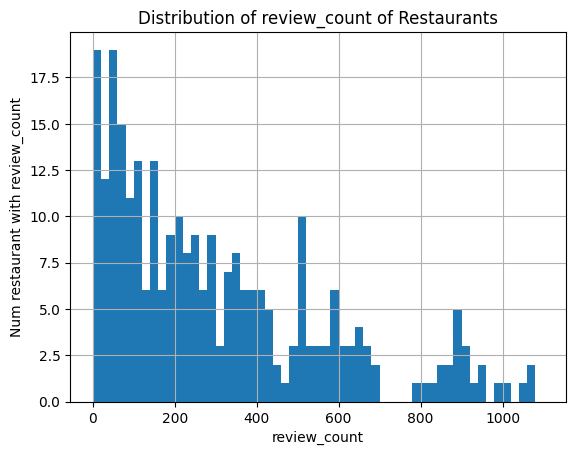

In [47]:
# Call plot_distribution on `threshold_df` with column `review_count`
plot_distribution(threshold_df, 'review_count', range(0, 1120, 20))

There seems to be quite a number of restaurants that are below $Q_1 = 84.75$. Nevertheless, as time passes, if those restaurants are ~~really good~~ *really edible*, then i'm sure they will pass that that $Q_1$ cut-off point in no time. It is also the case that my dad and I are only two people limited to the physical constraints of roughly $2-3$ meals per day, so I don't think there is an issue if we start with a smaller list.

With that said, I will move forward with a personal threshold of $84.75$, rounded up to $85$. Any restaurants with less than $85$ reviews in the Bay Tri-City Area will not be considered for trial. With this new filter, let's take a look what our modified `trial_df` looks like.

In [44]:
# Instantiate personal threshold from results computed above
personal_threshold = 85

# Create `trial_threshold_df` by filtering through `trial_df` with `personal_threshold`.`
trial_threshold_df = trial_df[trial_df['review_count'] >= personal_threshold]
removal_stats(trial_df, trial_threshold_df)

Number of tuples removed:     69
Proportion of tuples removed: 0.2331
Remaining tuples:             227


With $69$ (nice) restaurants removed from the list with my personal `review_count` threshold, I'm left with $227$ restaurants; seems like a good start. Now, it is finally time to use the `rating` feature. Just like how I determined my personal `review_count` threshold, I will use a similar process for `rating`. So to start, let's see the spread, summary statistics, and distribution.

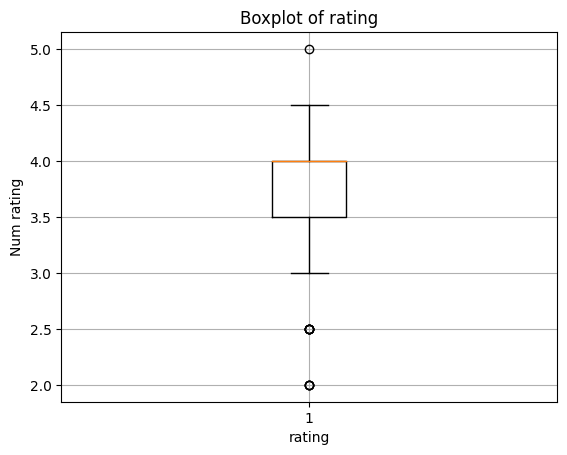

Summary Statistics:
count    227.000000
mean       3.863436
std        0.520664
min        2.000000
25%        3.500000
50%        4.000000
75%        4.000000
max        5.000000
Name: rating, dtype: float64


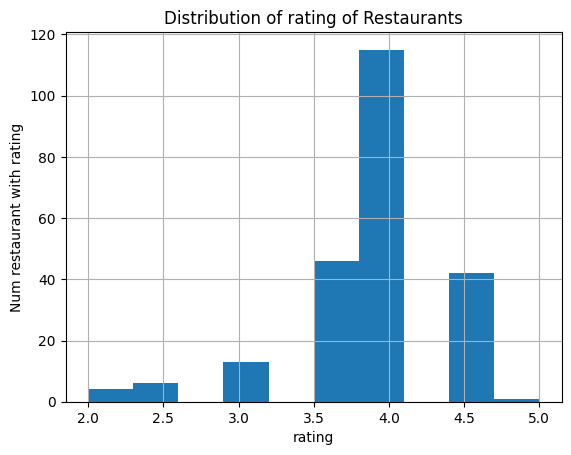

In [50]:
# Call previously implemented helper methods
boxplot_and_summary(trial_threshold_df, 'rating') # for spread and summary statistics
plot_distribution(trial_threshold_df, 'rating')


Looking at these statistics, my gut feeling is telling me to set a cutoff point at $4.0$, the rounded mean. But to include $4$ or not to include $4$ is now the main dilemma, as the distribution seems to be unimodal **AT** $4$, meaning if I do include $4$, a lot of restaurants will be included, and not doing so with eliminate a lot of them.

As I pondered about this for quite a while, I came to realization. ***It doesn't matter***. All these thresholds are made up ***BY ME***, and they can always be tweaked in the future. I'm not going to include $4$. Let's apply that filter.

In [55]:
# Apply filter on `trial_threshold_df` to create `final_trial_df``
final_trial_df = trial_threshold_df[trial_threshold_df['rating'] > 4]
removal_stats(trial_threshold_df, final_trial_df) # print removal stats

Number of tuples removed:    184
Proportion of tuples removed: 0.8106
Remaining tuples:              43


With $184$ restaurants removed, or rougly $81\%$ of the original DataFrame, I am left with $43$ restaurants.

Yeah, I can work with that.

Assuming we only eat out for dinner, so one restaurant each day, it'll take my dad and me about a month and half to test these restaurants. Not to mention, some of these restaurants we have already been to.

Let's take a look at the final DataFrame with the relevant columns projected, sorted by highest `rating`.

In [57]:
final_trial_df[['name', 'review_count', 'rating']].sort_values('rating', ascending=False)

,name,review_count,rating
130,Afghan Awasana Kabob,294,5.0
1,四姐 Pan Fried Dumplings,613,4.5
165,Momo & Kebab,416,4.5
169,Haleluya Ethiopian Gourmet,222,4.5
173,Kyain Kyain,413,4.5
179,Chicken Meets Rice,96,4.5
180,RāwASF - Fremont,191,4.5
182,Keeku da Dhaba,198,4.5
186,R HaanThai,111,4.5
196,Idly Express Fremont,106,4.5


And I see a lot of middle easter cuisines... oh boy. Guess it's time to experiment.

I'll report back in a month, maybe two months at most. Until then.